In [1]:
# Residual plots and heatmaps for difference in PKR functional scores between K3 conditions
# Figures 4 and 6

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib

In [8]:
# figure save directory
save_dir = "../../results/figures/residuals"
os.makedirs(save_dir, exist_ok=True)

In [9]:
input_file = '../../results/barseq/pkr-variant-reads_240228.csv'
df = pd.read_csv(input_file)

/tmp/ipykernel_3394128/1335287383.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_df.drop_duplicates(inplace=True)
/tmp/ipykernel_3394128/1335287383.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_df['site'] = wt_df['site'].astype(int)


K3-WT / K3Δ58 Residuals


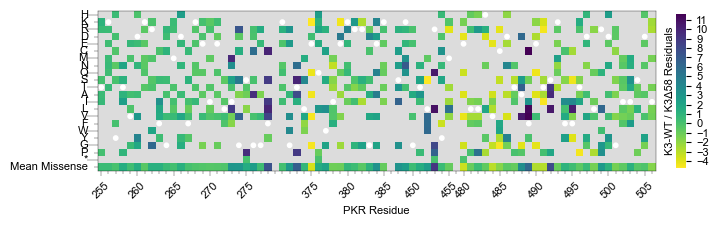

# RESIDUALS: K3-WT and K3Δ58
color #4/A #dcdcdc surface;color #4/A:255 #3bbb75 surface;color #4/A:256 #3bbb75 surface;color #4/A:257 #48c16e surface;color #4/A:258 #26ad81 surface;color #4/A:259 #40bd72 surface;color #4/A:260 #26ad81 surface;color #4/A:261 #58c765 surface;color #4/A:262 #2ab07f surface;color #4/A:263 #2ab07f surface;color #4/A:264 #3aba76 surface;color #4/A:265 #44bf70 surface;color #4/A:266 #2ab07f surface;color #4/A:267 #46c06f surface;color #4/A:268 #4ec36b surface;color #4/A:269 #52c569 surface;color #4/A:270 #56c667 surface;color #4/A:271 #54c568 surface;color #4/A:272 #50c46a surface;color #4/A:273 #1f968b surface;color #4/A:274 #1f978b surface;color #4/A:275 #25ac82 surface;color #4/A:276 #1e9d89 surface;color #4/A:277 #3fbc73 surface;color #4/A:278 #3b528b surface;color #4/A:371 #44bf70 surface;color #4/A:372 #1f998a surface;color #4/A:373 #355e8d surface;color #4/A:374 #34b679 surface;color #4/A:375 #d5e21a surface;color #4/A:376 #25ac82 surface;color #4/A:377

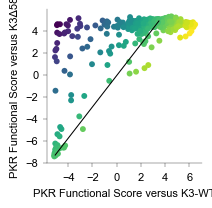

In [11]:
# RESIDUALS: K3-WT and K3Δ58
# heatmap and colored scatterplot
x_cond = "K3L-WT"
y_cond = "K3L-Null"

x_name = "K3-WT"
y_name = "K3Δ58"

# CALCULATIONS
# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
aa_no_stops = aa_list.copy()
aa_no_stops.remove("*")

width_in = 8
height_in = 4
stroke = .25
font = 'Arial'
font_size = 8
cmap_color = 'viridis_r'

pkr_region= (255,506)

# data
temp_df = df
pkr_resistant_vars = ['E375V','I378T','R382I','I405M','S448G','M455V','A473T','E480D','D486V','T491S','S504L','E524V']
def pkr_type(x, pkr_stop = 550):
    if x[-1] == "*" and int(x.split('-')[1][1:-1]) < pkr_stop:
        return "Nonsense"
    elif x.split('-')[1] in pkr_resistant_vars:
       return "Resistant Variant"
    else:
        return 'Variant'
temp_df['pkr_type'] = temp_df['pkr'].apply(pkr_type)
temp_df = temp_df.pivot_table(index=['pkr','pkr_type'], columns='k3', values='auc_mean').reset_index()

x = temp_df[x_cond].values
y = temp_df[y_cond].values

# points for line
# nonsense point
point = temp_df.query('pkr_type == "Nonsense"')[[x_cond,y_cond]].mean()
point1 = (point[0],point[1])

# wt point
point = temp_df.query('pkr == "PKR-WT"')[[x_cond,y_cond]].mean()
point2 = (point[0],point[1])

# Calculate the slope and intercept of the line
slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
intercept = point1[1] - slope * point1[0]

# Calculate residuals (vertical distances from points to the line)
temp_df['residuals'] = (y - (slope * x + intercept))

# create necessary columns
temp_df = temp_df.query('pkr != "PKR-WT"')
temp_df['site'] = temp_df['pkr'].str[-4:-1].astype(int)
temp_df['wt_aa'] = temp_df['pkr'].str[-5]
temp_df['var_aa'] = temp_df['pkr'].str[-1]


# HEATMAP
# custom cmap
custom_cmap = mpl.colormaps[cmap_color]
custom_cmap.set_bad(color='gainsboro')
norm = plt.Normalize(temp_df['residuals'].min(), temp_df['residuals'].max())

# filter down to region sites
region_site_list = list(range(pkr_region[0], pkr_region[1]+1))
region_df = temp_df[temp_df['site'].isin(region_site_list)]
region_df['site'] = region_df['site'].astype(int)

# remove wt
region_df = region_df.query('pkr != "PKR-WT"')

cols = ['site','wt_aa']
wt_df = region_df[cols]
wt_df.drop_duplicates(inplace=True)
wt_df['site'] = wt_df['site'].astype(int)
wt_df = wt_df.sort_values('site')
wt_df.set_index('site', inplace=True)
wt_df= pd.get_dummies(wt_df['wt_aa'])
missing_wt = list(set(aa_list) - set(wt_df.columns.tolist()))
for aa in missing_wt:
    wt_df[aa] = False

# use for black circles
wt_df = wt_df[aa_list]
wt_df.replace({True:1, False:np.nan}, inplace=True)
wt_df['Mean Missense'] = np.nan
wt_df = wt_df.T
wt_df[279] = np.nan
wt_df[386] = np.nan
wt_df[456] = np.nan
sorted_cols = sorted(wt_df.columns.tolist())
wt_df = wt_df[sorted_cols]
wt_array = wt_df.values

# this drops missing dataframes
region_df = region_df.pivot(index='site',columns='var_aa', values='residuals')
region_df = region_df[aa_list]
region_df['Mean Missense'] = region_df[aa_no_stops].mean(axis=1)
region_df = region_df.T
region_df[279] = np.nan
region_df[386] = np.nan
region_df[456] = np.nan
sorted_cols = sorted(region_df.columns.tolist())
region_df = region_df[sorted_cols]

font = {'family': font, 'size': font_size}
plt.figure(figsize=(width_in, height_in))

# Define size and location of the colorbar
min_value = region_df.min().min()
max_value = region_df.max().max()
even_ticks = np.arange(np.ceil(min_value), np.floor(max_value) + 1, 1)

cbar_kws = {
    'aspect':15,
    'orientation':'vertical',
    'fraction':.05,
    'pad':.05,
    'shrink':.5,
    'anchor':(-.5,.5),
    'ticks':even_ticks,
} 

g = sns.heatmap(
    data=region_df,
    cmap=custom_cmap,
    norm=norm,
    square=True,
    cbar_kws=cbar_kws
)

# wt black circles
for i in range(len(wt_array)):
    for j in range(len(wt_array[i])):
        if np.isnan(wt_array[i, j]):
            continue  # Skip NaN values
        if wt_array[i, j] == 1:  # Replace black cells with circles
            circle = plt.Circle((j + 0.5, i + 0.5), 0.3, color='white', fill=True)
            g.add_artist(circle)

# final alterations of colorbar
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label(f"{x_name} / {y_name} Residuals", rotation=90, labelpad=1, font=font, size=font_size)
cbar.ax.yaxis.set_label_position('left')

# Labels
# Set font properties for x and y tick labels
plt.xticks(fontproperties=font, fontsize=font_size)
plt.yticks(fontproperties=font, fontsize=font_size)

g.set_ylabel('')
g.set_xlabel('PKR Residue', font=font, size=font_size)

# Y labels
# Add y ticks for all labels
g.set_yticks(np.arange(len(region_df.index)) + 0.5)

# Rotate labels
g.set_yticklabels(region_df.index, rotation=0, fontproperties=font)

# Set linewidth for both major and minor ticks
plt.tick_params(axis='both', which='both', width=stroke)

# Get the y-axis major ticks
major_ticks = plt.gca().yaxis.get_major_ticks()

# Iterate over the ticks and labels
for i, tick in enumerate(major_ticks):
    # Determine tick length based on even or odd iteration
    tick_length = 8 if i % 2 == 0 else 3
    tick.tick1line.set_markersize(tick_length)

# Set major ticks and labels to values evenly divisible by 5
x_index = []
x_value = []
for i,x in enumerate(region_df.columns.tolist()):
    if x % 5 == 0:
        x_index.append(i+0.5)
        x_value.append(x)
g.set_xticks(x_index)
g.set_xticklabels(x_value, fontproperties=font, rotation=45)

# Show minor ticks
g.set_xticks(np.arange(len(region_df.columns)) + 0.5, minor=True)

for spine in g.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(stroke)
    spine.set_edgecolor('black')

#plt.rcParams['font.family'] = font
#plt.rcParams['font.size'] = font_size

# save plot
plot_name = f'pkr-residuals_{x_name}_{y_name}_heatmap_{width_in}x{height_in}.svg'
output_file = os.path.join(save_dir, plot_name)
plt.savefig(output_file, bbox_inches='tight', format='svg', transparent=True)


print(f"{x_name} / {y_name} Residuals")
plt.show()


# STRUCTURE
# get mean_auc values from region_df
values = region_df.T['Mean Missense'].values

# colormap
my_cmap = plt.cm.viridis_r

# remove nan
values = values[~np.isnan(values)]

# normalize data range 
norm = mcolors.Normalize(vmin=temp_df['residuals'].min(), vmax=temp_df['residuals'].max())

colors = [my_cmap(norm(value)) for value in values.flatten()] # get colors corresponding to values
hex_colors = [mcolors.to_hex(color) for color in colors]

# get ordered sites list
pkr_sites = sorted(list(set(df.query('pkr != "PKR-WT"')['site'].astype(int).tolist())))

cmd_list = []
for site, color in zip(pkr_sites, hex_colors):
    cmd_list.append(f"color #4/A:{site} {color} surface;")

print(f'# RESIDUALS: {x_name} and {y_name}')
print(''.join(['color #4/A #dcdcdc surface;'] + cmd_list))

# SCATTERPLOT
# format figure
width_in = 2
height_in = 2
font_size = 8
font_name = 'Arial'
stroke = .25
tick_len = 3
alpha_val = 1
marker_diameter = 3 # 1.75

font = {'family': font_name, 'size': font_size}
plt.rc('font', **font)
plt.rc('lines', linewidth=stroke)
plt.figure(figsize=(width_in, height_in)) # save size

# plot variants
ax = sns.scatterplot(
    data=temp_df,
    x = x_cond,
    y = y_cond,
    hue='residuals',
    palette='viridis_r',
    size=marker_diameter,
    legend=False,
    edgecolor='none',
    alpha=alpha_val
)

# Set x and y limits
#ax.set_xlim(-7, 8)
#ax.set_ylim(-9, 8)

# plot line
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black', linestyle='-', linewidth=.75)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(stroke)
ax.spines['bottom'].set_linewidth(stroke)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='out', length=3, width=stroke)

# Set font properties for axis labels
ax.set_xlabel(f'PKR Functional Score versus {x_name}', fontsize=font_size, fontname=font_name)
ax.set_ylabel(f'PKR Functional Score versus {y_name}', fontsize=font_size, fontname=font_name)

# Set tick marks and labels every 5 units
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

plot_name = f'pkr-residuals_{x_name}_{y_name}_scatterplot_{width_in}x{height_in}.svg'
output_file = os.path.join(save_dir, plot_name)
plt.savefig(output_file, bbox_inches='tight', format='svg', transparent=True)

/tmp/ipykernel_3394128/3316105732.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_df.drop_duplicates(inplace=True)
/tmp/ipykernel_3394128/3316105732.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_df['site'] = wt_df['site'].astype(int)


K3-WT / K3-H47R Residuals


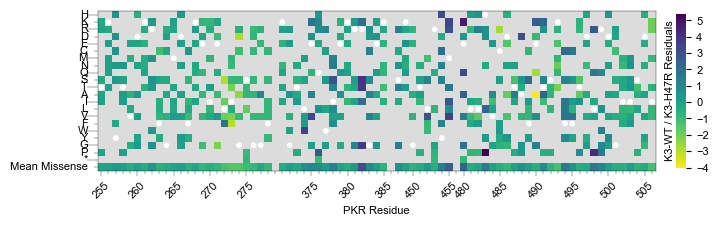

# RESIDUALS: K3-WT / K3-H47R
color #4/A #dcdcdc cartoon;color #4/A:255 #21a685 cartoon;color #4/A:256 #20a386 cartoon;color #4/A:257 #1f998a cartoon;color #4/A:258 #1fa088 cartoon;color #4/A:259 #26ad81 cartoon;color #4/A:260 #1fa287 cartoon;color #4/A:261 #26ad81 cartoon;color #4/A:262 #1f988b cartoon;color #4/A:263 #2ab07f cartoon;color #4/A:264 #25ab82 cartoon;color #4/A:265 #20a486 cartoon;color #4/A:266 #1fa088 cartoon;color #4/A:267 #28ae80 cartoon;color #4/A:268 #22a785 cartoon;color #4/A:269 #31b57b cartoon;color #4/A:270 #29af7f cartoon;color #4/A:271 #31b57b cartoon;color #4/A:272 #44bf70 cartoon;color #4/A:273 #52c569 cartoon;color #4/A:274 #52c569 cartoon;color #4/A:275 #3fbc73 cartoon;color #4/A:276 #35b779 cartoon;color #4/A:277 #24aa83 cartoon;color #4/A:278 #34b679 cartoon;color #4/A:371 #25ac82 cartoon;color #4/A:372 #1fa088 cartoon;color #4/A:373 #23a983 cartoon;color #4/A:374 #218f8d cartoon;color #4/A:375 #23888e cartoon;color #4/A:376 #228c8d cartoon;color #4/A:377

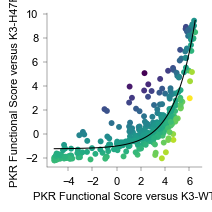

In [14]:
# RESIDUALS: K3-WT / K3-H47R (curved linear model)
# heatmap and colored scatterplot
x_cond = "K3L-WT"
y_cond = "K3L-H47R"

x_name = "K3-WT"
y_name = "K3-H47R"

# CALCULATIONS
# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
aa_no_stops = aa_list.copy()
aa_no_stops.remove("*")

width_in = 8
height_in = 4
stroke = .25
font = 'Arial'
font_size = 8
cmap_color = 'viridis_r'

pkr_region= (255,506)

# data
temp_df = df
pkr_resistant_vars = ['E375V','I378T','R382I','I405M','S448G','M455V','A473T','E480D','D486V','T491S','S504L','E524V']
def pkr_type(x, pkr_stop = 550):
    if x[-1] == "*" and int(x.split('-')[1][1:-1]) < pkr_stop:
        return "Nonsense"
    elif x.split('-')[1] in pkr_resistant_vars:
       return "Resistant Variant"
    else:
        return 'Variant'
temp_df['pkr_type'] = temp_df['pkr'].apply(pkr_type)
temp_df = temp_df.pivot_table(index=['pkr','pkr_type'], columns='k3', values='auc_mean').reset_index()


# Define your dataset
x_data = temp_df[x_cond].values
y_data = temp_df[y_cond].values

# Define the exponential growth function with vertical offset
def exponential_function_with_offset(x, a, b, c):
    """Exponential growth function with vertical offset
    a - amplitude of exponential growth
    b - rate of growth
    c - vertical offset
    """
    return a * np.exp(b * x) + c


# Use curve_fit to fit the exponential function to your data
params, covariance = curve_fit(exponential_function_with_offset, x_data, y_data)

# Calculate the fitted y-values
fitted_y = exponential_function_with_offset(x_data, *params)

# Calculate residuals
temp_df['residuals'] = y_data - fitted_y


# HEATMAP
# create necessary columns
temp_df = temp_df.query('pkr != "PKR-WT"')
temp_df['site'] = temp_df['pkr'].str[-4:-1].astype(int)
temp_df['wt_aa'] = temp_df['pkr'].str[-5]
temp_df['var_aa'] = temp_df['pkr'].str[-1]

# custom cmap
custom_cmap = mpl.colormaps[cmap_color]
custom_cmap.set_bad(color='gainsboro')
norm = plt.Normalize(temp_df['residuals'].min(), temp_df['residuals'].max())

# filter down to region sites
region_site_list = list(range(pkr_region[0], pkr_region[1]+1))
region_df = temp_df[temp_df['site'].isin(region_site_list)]
region_df['site'] = region_df['site'].astype(int)

# remove wt
region_df = region_df.query('pkr != "PKR-WT"')

cols = ['site','wt_aa']
wt_df = region_df[cols]
wt_df.drop_duplicates(inplace=True)
wt_df['site'] = wt_df['site'].astype(int)
wt_df = wt_df.sort_values('site')
wt_df.set_index('site', inplace=True)
wt_df= pd.get_dummies(wt_df['wt_aa'])
missing_wt = list(set(aa_list) - set(wt_df.columns.tolist()))
for aa in missing_wt:
    wt_df[aa] = False

# use for black circles
wt_df = wt_df[aa_list]
wt_df.replace({True:1, False:np.nan}, inplace=True)
wt_df['Mean Missense'] = np.nan
wt_df = wt_df.T
wt_df[279] = np.nan
wt_df[386] = np.nan
wt_df[456] = np.nan
sorted_cols = sorted(wt_df.columns.tolist())
wt_df = wt_df[sorted_cols]
wt_array = wt_df.values

# this drops missing dataframes
region_df = region_df.pivot(index='site',columns='var_aa', values='residuals')
region_df = region_df[aa_list]
region_df['Mean Missense'] = region_df[aa_no_stops].mean(axis=1)
region_df = region_df.T
region_df[279] = np.nan
region_df[386] = np.nan
region_df[456] = np.nan
sorted_cols = sorted(region_df.columns.tolist())
region_df = region_df[sorted_cols]

font = {'family': font, 'size': font_size}
plt.figure(figsize=(width_in, height_in))

# Define size and location of the colorbar
min_value = region_df.min().min()
max_value = region_df.max().max()
even_ticks = np.arange(np.ceil(min_value), np.floor(max_value) + 1, 1)

cbar_kws = {
    'aspect':15,
    'orientation':'vertical',
    'fraction':.05,
    'pad':.05,
    'shrink':.5,
    'anchor':(-.5,.5),
    'ticks':even_ticks,
}  

g = sns.heatmap(
    data=region_df,
    cmap=custom_cmap,
    norm=norm,
    square=True,
    cbar_kws=cbar_kws
)

# wt black circles
for i in range(len(wt_array)):
    for j in range(len(wt_array[i])):
        if np.isnan(wt_array[i, j]):
            continue  # Skip NaN values
        if wt_array[i, j] == 1:  # Replace black cells with circles
            circle = plt.Circle((j + 0.5, i + 0.5), 0.3, color='white', fill=True)
            g.add_artist(circle)

# final alterations of colorbar
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label(f"{x_name} / {y_name} Residuals", rotation=90, labelpad=1, font=font, size=font_size)
cbar.ax.yaxis.set_label_position('left')

# Labels
# Set font properties for x and y tick labels
plt.xticks(fontproperties=font, fontsize=font_size)
plt.yticks(fontproperties=font, fontsize=font_size)

g.set_ylabel('')
g.set_xlabel('PKR Residue', font=font, size=font_size)

# Y labels
# Add y ticks for all labels
g.set_yticks(np.arange(len(region_df.index)) + 0.5)

# Rotate labels
g.set_yticklabels(region_df.index, rotation=0, fontproperties=font)

# Set linewidth for both major and minor ticks
plt.tick_params(axis='both', which='both', width=stroke)

# Get the y-axis major ticks
major_ticks = plt.gca().yaxis.get_major_ticks()

# Iterate over the ticks and labels
for i, tick in enumerate(major_ticks):
    # Determine tick length based on even or odd iteration
    tick_length = 8 if i % 2 == 0 else 3
    tick.tick1line.set_markersize(tick_length)

# Set major ticks and labels to values evenly divisible by 5
x_index = []
x_value = []
for i,x in enumerate(region_df.columns.tolist()):
    if x % 5 == 0:
        x_index.append(i+0.5)
        x_value.append(x)
g.set_xticks(x_index)
g.set_xticklabels(x_value, fontproperties=font, rotation=45)

# Show minor ticks
g.set_xticks(np.arange(len(region_df.columns)) + 0.5, minor=True)

for spine in g.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(stroke)
    spine.set_edgecolor('black')

#plt.rcParams['font.family'] = font
#plt.rcParams['font.size'] = font_size

# save figure
plot_name = f'pkr-residuals_{x_name}_{y_name}_heatmap_{width_in}x{height_in}.svg'
output_file = os.path.join(save_dir, plot_name)
plt.savefig(output_file, bbox_inches='tight', format='svg', transparent=True)

print(f"{x_name} / {y_name} Residuals")
plt.show()
plt.close()


# STRUCTURE COLORS
# get mean_auc values from region_df
values = region_df.T['Mean Missense'].values
values = values[~np.isnan(values)]
# colormap
#my_cmap = plt.cm.viridis_r

# normalize data range 
#norm = mcolors.Normalize(vmin=temp_df['residuals'].min(), vmax=temp_df['residuals'].max())

colors = [custom_cmap(norm(value)) for value in values.flatten()] # get colors corresponding to values
hex_colors = [mcolors.to_hex(color) for color in colors]

# get ordered sites list
pkr_sites = sorted(list(set(df.query('pkr != "PKR-WT"')['site'].astype(int).tolist())))

cmd_list = []
for site, color in zip(pkr_sites, hex_colors):
    cmd_list.append(f"color #4/A:{site} {color} cartoon;")

print(f'# RESIDUALS: {x_name} / {y_name}')
print(''.join(['color #4/A #dcdcdc cartoon;'] + cmd_list))


# SCATTERPLOT
# format figure
width_in = 2
height_in = 2
font_size = 8
font_name = 'Arial'
stroke = .25
tick_len = 3
alpha_val = 1
marker_diameter = 3 # 1.75

font = {'family': font_name, 'size': font_size}
plt.rc('font', **font)
plt.rc('lines', linewidth=stroke)
plt.figure(figsize=(width_in, height_in)) # save size

# plot variants
ax = sns.scatterplot(
    data=temp_df,
    x = x_cond,
    y = y_cond,
    hue='residuals',
    palette='viridis_r',
    size=marker_diameter,
    legend=False,
    edgecolor='none',
    alpha=alpha_val
)

# Plot the curve of best fit
x_dense = np.linspace(min(x_data), max(x_data), 100)
fitted_curve = exponential_function_with_offset(x_dense, *params)
plt.plot(x_dense, fitted_curve, color='black', label='Curve of Best Fit', linewidth=.75)

# Set x and y limits
#ax.set_xlim(-3, 10)
#ax.set_ylim(-8, 6)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(stroke)
ax.spines['bottom'].set_linewidth(stroke)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='out', length=3, width=stroke)

# Set font properties for axis labels
ax.set_xlabel(f'PKR Functional Score versus {x_name}', fontsize=font_size, fontname=font_name)
ax.set_ylabel(f'PKR Functional Score versus {y_name}', fontsize=font_size, fontname=font_name)

# Set tick marks and labels every 5 units
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

plot_name = f'pkr-residuals_{x_name}_{y_name}_scatterplot_{width_in}x{height_in}.svg'
output_file = os.path.join(save_dir, plot_name)
plt.savefig(output_file, bbox_inches='tight', format='svg', transparent=True)

/tmp/ipykernel_3036575/535925285.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_df.drop_duplicates(inplace=True)
/tmp/ipykernel_3036575/535925285.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_df['site'] = wt_df['site'].astype(int)


K3-H47R / K3Δ58 Residuals


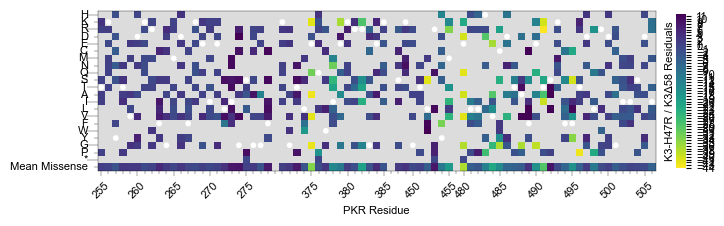

# RESIDUALS: K3-H47R and K3Δ58
color #4/A #dcdcdc surface;color #4/A:255 #433e85 surface;color #4/A:256 #414287 surface;color #4/A:257 #3a538b surface;color #4/A:258 #453781 surface;color #4/A:259 #443b84 surface;color #4/A:260 #443983 surface;color #4/A:261 #3e4989 surface;color #4/A:262 #414287 surface;color #4/A:263 #482878 surface;color #4/A:264 #443983 surface;color #4/A:265 #404688 surface;color #4/A:266 #453781 surface;color #4/A:267 #404688 surface;color #4/A:268 #3e4989 surface;color #4/A:269 #423f85 surface;color #4/A:270 #3f4788 surface;color #4/A:271 #424186 surface;color #4/A:272 #46327e surface;color #4/A:273 #48186a surface;color #4/A:274 #481668 surface;color #4/A:275 #424086 surface;color #4/A:276 #443983 surface;color #4/A:277 #3a538b surface;color #4/A:278 #481a6c surface;color #4/A:371 #423f85 surface;color #4/A:372 #453781 surface;color #4/A:373 #481b6d surface;color #4/A:374 #39558c surface;color #4/A:375 #84d44b surface;color #4/A:376 #3d4d8a surface;color #4/A:3

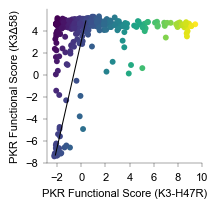

In [5]:
# EXTRA
# RESIDUALS: K3-H47R and K3Δ58
x_cond = "K3L-H47R"
y_cond = "K3L-Null"

x_name = "K3-H47R"
y_name = "K3Δ58"

# CALCULATIONS
# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
aa_no_stops = aa_list.copy()
aa_no_stops.remove("*")

width_in = 8
height_in = 4
stroke = .25
font = 'Arial'
font_size = 8
cmap_color = 'viridis_r'

pkr_region= (255,506)

# data
temp_df = df
pkr_resistant_vars = ['E375V','I378T','R382I','I405M','S448G','M455V','A473T','E480D','D486V','T491S','S504L','E524V']
def pkr_type(x, pkr_stop = 550):
    if x[-1] == "*" and int(x.split('-')[1][1:-1]) < pkr_stop:
        return "Nonsense"
    elif x.split('-')[1] in pkr_resistant_vars:
       return "Resistant Variant"
    else:
        return 'Variant'
temp_df['pkr_type'] = temp_df['pkr'].apply(pkr_type)
temp_df = temp_df.pivot_table(index=['pkr','pkr_type'], columns='k3', values='auc_mean').reset_index()

x = temp_df[x_cond].values
y = temp_df[y_cond].values

# points for line
# nonsense point
point = temp_df.query('pkr_type == "Nonsense"')[[x_cond,y_cond]].mean()
point1 = (point[0],point[1])

# wt point
point = temp_df.query('pkr == "PKR-WT"')[[x_cond,y_cond]].mean()
point2 = (point[0],point[1])

# Calculate the slope and intercept of the line
slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
intercept = point1[1] - slope * point1[0]

# Calculate residuals (vertical distances from points to the line)
temp_df['residuals'] = (y - (slope * x + intercept))

# create necessary columns
temp_df = temp_df.query('pkr != "PKR-WT"')
temp_df['site'] = temp_df['pkr'].str[-4:-1].astype(int)
temp_df['wt_aa'] = temp_df['pkr'].str[-5]
temp_df['var_aa'] = temp_df['pkr'].str[-1]


# HEATMAP
# custom cmap
custom_cmap = mpl.colormaps[cmap_color]
custom_cmap.set_bad(color='gainsboro')
norm = plt.Normalize(temp_df['residuals'].min(), temp_df['residuals'].max())

# filter down to region sites
region_site_list = list(range(pkr_region[0], pkr_region[1]+1))
region_df = temp_df[temp_df['site'].isin(region_site_list)]
region_df['site'] = region_df['site'].astype(int)

# remove wt
region_df = region_df.query('pkr != "PKR-WT"')

cols = ['site','wt_aa']
wt_df = region_df[cols]
wt_df.drop_duplicates(inplace=True)
wt_df['site'] = wt_df['site'].astype(int)
wt_df = wt_df.sort_values('site')
wt_df.set_index('site', inplace=True)
wt_df= pd.get_dummies(wt_df['wt_aa'])
missing_wt = list(set(aa_list) - set(wt_df.columns.tolist()))
for aa in missing_wt:
    wt_df[aa] = False

# use for black circles
wt_df = wt_df[aa_list]
wt_df.replace({True:1, False:np.nan}, inplace=True)
wt_df['Mean Missense'] = np.nan
wt_df = wt_df.T
wt_df[279] = np.nan
wt_df[386] = np.nan
wt_df[456] = np.nan
sorted_cols = sorted(wt_df.columns.tolist())
wt_df = wt_df[sorted_cols]
wt_array = wt_df.values

# this drops missing dataframes
region_df = region_df.pivot(index='site',columns='var_aa', values='residuals')
region_df = region_df[aa_list]
region_df['Mean Missense'] = region_df[aa_no_stops].mean(axis=1)
region_df = region_df.T
region_df[279] = np.nan
region_df[386] = np.nan
region_df[456] = np.nan
sorted_cols = sorted(region_df.columns.tolist())
region_df = region_df[sorted_cols]

font = {'family': font, 'size': font_size}
plt.figure(figsize=(width_in, height_in))

# Define size and location of the colorbar
min_value = region_df.min().min()
max_value = region_df.max().max()
even_ticks = np.arange(np.ceil(min_value), np.floor(max_value) + 1, 1)

cbar_kws = {
    'aspect':15,
    'orientation':'vertical',
    'fraction':.05,
    'pad':.05,
    'shrink':.5,
    'anchor':(-.5,.5),
    'ticks':even_ticks,
} 

g = sns.heatmap(
    data=region_df,
    cmap=custom_cmap,
    norm=norm,
    square=True,
    cbar_kws=cbar_kws
)

# wt black circles
for i in range(len(wt_array)):
    for j in range(len(wt_array[i])):
        if np.isnan(wt_array[i, j]):
            continue  # Skip NaN values
        if wt_array[i, j] == 1:  # Replace black cells with circles
            circle = plt.Circle((j + 0.5, i + 0.5), 0.3, color='white', fill=True)
            g.add_artist(circle)

# final alterations of colorbar
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label(f"{x_name} / {y_name} Residuals", rotation=90, labelpad=1, font=font, size=font_size)
cbar.ax.yaxis.set_label_position('left')

# Labels
# Set font properties for x and y tick labels
plt.xticks(fontproperties=font, fontsize=font_size)
plt.yticks(fontproperties=font, fontsize=font_size)

g.set_ylabel('')
g.set_xlabel('PKR Residue', font=font, size=font_size)

# Y labels
# Add y ticks for all labels
g.set_yticks(np.arange(len(region_df.index)) + 0.5)

# Rotate labels
g.set_yticklabels(region_df.index, rotation=0, fontproperties=font)

# Set linewidth for both major and minor ticks
plt.tick_params(axis='both', which='both', width=stroke)

# Get the y-axis major ticks
major_ticks = plt.gca().yaxis.get_major_ticks()

# Iterate over the ticks and labels
for i, tick in enumerate(major_ticks):
    # Determine tick length based on even or odd iteration
    tick_length = 8 if i % 2 == 0 else 3
    tick.tick1line.set_markersize(tick_length)

# Set major ticks and labels to values evenly divisible by 5
x_index = []
x_value = []
for i,x in enumerate(region_df.columns.tolist()):
    if x % 5 == 0:
        x_index.append(i+0.5)
        x_value.append(x)
g.set_xticks(x_index)
g.set_xticklabels(x_value, fontproperties=font, rotation=45)

# Show minor ticks
g.set_xticks(np.arange(len(region_df.columns)) + 0.5, minor=True)

for spine in g.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(stroke)
    spine.set_edgecolor('black')

#plt.rcParams['font.family'] = font
#plt.rcParams['font.size'] = font_size

# Save the plot as a .svg file
plot_name = f'pkr-residuals_{x_name}_{y_name}_heatmap_{width_in}x{height_in}.svg'
output_file = os.path.join(save_dir, plot_name)
#plt.savefig(output_file, bbox_inches='tight', format='svg', transparent=True)

print(f"{x_name} / {y_name} Residuals")
plt.show()


# STRUCTURE
# get mean_auc values from region_df
values = region_df.T['Mean Missense'].values

# colormap
my_cmap = plt.cm.viridis_r

# remove nan
values = values[~np.isnan(values)]

# normalize data range 
norm = mcolors.Normalize(vmin=temp_df['residuals'].min(), vmax=temp_df['residuals'].max())

colors = [my_cmap(norm(value)) for value in values.flatten()] # get colors corresponding to values
hex_colors = [mcolors.to_hex(color) for color in colors]

# get ordered sites list
pkr_sites = sorted(list(set(df.query('pkr != "PKR-WT"')['site'].astype(int).tolist())))

cmd_list = []
for site, color in zip(pkr_sites, hex_colors):
    cmd_list.append(f"color #4/A:{site} {color} surface;")

print(f'# RESIDUALS: {x_name} and {y_name}')
print(''.join(['color #4/A #dcdcdc surface;'] + cmd_list))


# SCATTERPLOT
# format figure
width_in = 2
height_in = 2
font_size = 8
font_name = 'Arial'
stroke = .25
tick_len = 3
alpha_val = 1
marker_diameter = 3 # 1.75

font = {'family': font_name, 'size': font_size}
plt.rc('font', **font)
plt.rc('lines', linewidth=stroke)
plt.figure(figsize=(width_in, height_in)) # save size

# plot variants
ax = sns.scatterplot(
    data=temp_df,
    x = x_cond,
    y = y_cond,
    hue='residuals',
    palette='viridis_r',
    size=marker_diameter,
    legend=False,
    edgecolor='none',
    alpha=alpha_val
)

# Set x and y limits
#ax.set_xlim(-7, 8)
#ax.set_ylim(-9, 8)

# plot line
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black', linestyle='-', linewidth=.75)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(stroke)
ax.spines['bottom'].set_linewidth(stroke)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='out', length=3, width=stroke)

# Set font properties for axis labels
ax.set_xlabel(f'PKR Functional Score versus {x_name}', fontsize=font_size, fontname=font_name)
ax.set_ylabel(f'PKR Functional Score versus {y_name}', fontsize=font_size, fontname=font_name)

# Set tick marks and labels every 5 units
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

plot_name = f'pkr-residuals_{x_name}_{y_name}_scatterplot_{width_in}x{height_in}.svg'
output_file = os.path.join(save_dir, plot_name)
#plt.savefig(output_file, bbox_inches='tight', format='svg', transparent=True)